In [1]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from parse import *
import seaborn as sns

In [2]:
CHUNKSIZE = 100000

TRAIN_PATH        = "../../data/train_StationPathInfo.csv"
TRAIN_PATH_EX     = "../../data/train_StationPathInfoEx.csv"
TEST_PATH         = "../../data/test_StationPathInfo.csv"
TEST_PATH_EX      = "../../data/test_StationPathInfoEx.csv"

SEED = 0
CHUNKSIZE = 50000
NROWS = 1200000

ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
    
    
    

In [3]:
# 読み出す。

df_train_bin = pd.read_csv(TRAIN_PATH)
df_test_bin  = pd.read_csv(TEST_PATH)


通過ステーションをヒートマップにしてみる。

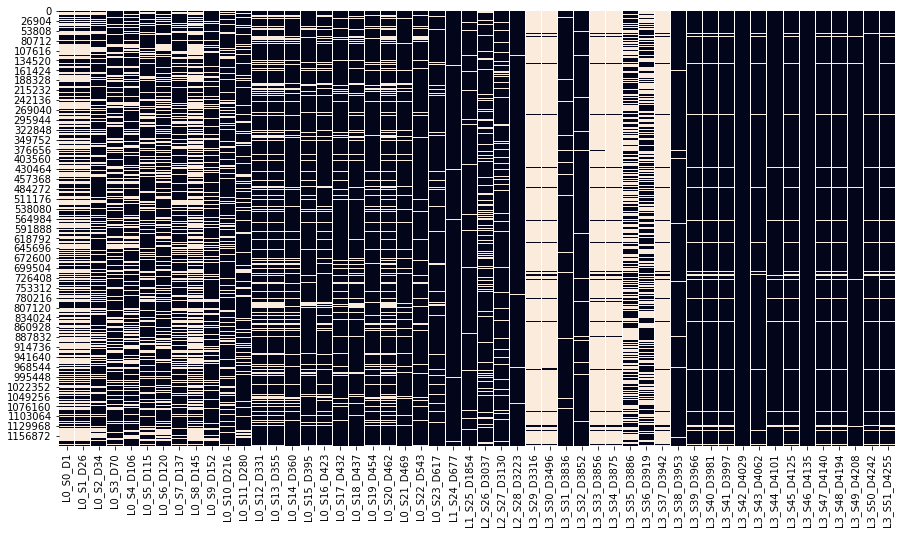

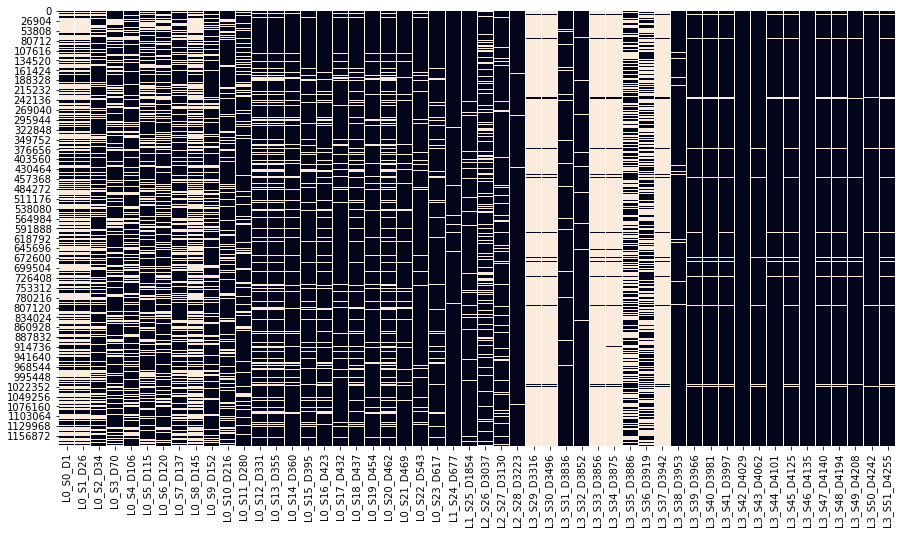

In [4]:
matplotlib.pyplot.rcParams['figure.figsize'] = (15.0, 8.0)
sns.heatmap(df_train_bin.drop(['Id'], axis=1), annot=False, cbar=False)
plt.show()
sns.heatmap(df_test_bin.drop(['Id'], axis=1),  annot=False, cbar=False)
plt.show()



上流部分は、以下の同じパターンが見える。
(ヒートマップはいずれか一か所がたつと濃く見えるので、この中で散らばっている可能性がある。)
どっちも通っていない製品があるかもしれない。<br>
S00 - S01 - (S02 or S03) - (S04 or S06 or S05 - S07) - S08 - (S09 or S10 or S11) <br>
S12 - S13 - (S14 or S15) - (S16 or S17)  - (S18 or S19) - S20 - (S21 or S22 or S23)<br>
S26<br>

でも細かく見てみたらそんなに単純じゃないことがわかった。



<br>
<br>
下流部分? で、おもに以下の2つの流れが見える。<br>
S29 - S30 - S33 - S34 - (S35 or S36) - S37<br>
S39 - S40 - S41 - S43 - S45 - S47 - S48 - (S49 or S50) - S51<br> 



S00, S12を通らない製品のパス → S1を通ってる…

In [5]:
df_skip = df_train_bin[(df_train_bin['L0_S0_D1'] == 0)  & (df_train_bin['L0_S12_D331'] == 0)]
columns = df_skip.columns
for col in columns:
    df_tmp = df_skip[df_skip[col] != 0]
    if 0 == len(df_tmp):
        print(col)
        df_skip = df_skip.drop(col, axis=1)
df_skip[df_skip['L0_S1_D26']== 1].head(5)
    




L0_S0_D1
L0_S12_D331
L3_S46_D4135


,Id,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,L0_S9_D152,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
568,1117,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1383,2808,1,1,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1384,2809,1,1,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4470,8906,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4506,8990,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


S0 ～ S5 がクラスタを構成している。
(S0-S5) - (S6-S11) の構成になってるようだ。

In [6]:
df_s1_11_skip = df_train_bin[(df_train_bin['L0_S0_D1'] == 0) 
                        & (df_train_bin['L0_S1_D26'] == 0)
                        & (df_train_bin['L0_S2_D34'] == 0)
                        & (df_train_bin['L0_S3_D70'] == 0)
                        & (df_train_bin['L0_S4_D106'] == 0)
                        & (df_train_bin['L0_S5_D115'] == 0)
]

def drop_allzero_columns(df):
    columns = df.columns
    for col in columns:
        df_tmp = df[df[col] != 0]
        if 0 == len(df_tmp):
            print(col)
            df = df.drop(col, axis=1)
    return df

df_s1_11_skip = drop_allzero_columns(df_s1_11_skip)
print(len(df_s1_11_skip))
df_s1_11_skip.head(5)

L0_S0_D1
L0_S1_D26
L0_S2_D34
L0_S3_D70
L0_S4_D106
L0_S5_D115
L0_S6_D120
L0_S7_D137
L0_S8_D145
L0_S9_D152
L0_S10_D216
L0_S11_D280
L3_S46_D4135
509031


,Id,L0_S12_D331,L0_S13_D355,L0_S14_D360,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
1,6,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,14,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,23,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
16,41,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_s1_11_pass = df_train_bin[
    (df_train_bin['L0_S0_D1'] == 1) 
    | (df_train_bin['L0_S1_D26'] == 1)
    | (df_train_bin['L0_S2_D34'] == 1)
    | (df_train_bin['L0_S3_D70'] == 1)
    | (df_train_bin['L0_S4_D106'] == 1)
    | (df_train_bin['L0_S5_D115'] == 1)
]

print(len(df_s1_11_pass))
df_s1_11_pass.head(5)

674716


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
0,4,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,11,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,13,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


使えるかどうかはわからんが、S1-S5 を通るものは、S46 を必ず通るようだ。


S1-S5 を外したものから、以下の構成が読める。
S12 - S13 - (S14 or S15) - (S16 or S17) - (S18 or S19)

In [8]:
df_s01_s05_s12_skip = df_s1_11_skip[df_s1_11_skip['L0_S12_D331'] == 0]

df_s01_s05_s12_skip = drop_allzero_columns(df_s01_s05_s12_skip)
df_s01_s05_s12_skip.head(5)                                    

L0_S12_D331


,Id,L0_S13_D355,L0_S14_D360,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,L0_S21_D469,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
7,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


S12 と S13 の両方を通るものもいれば、<br>
S13しか通らないものもいる。4つしかいない。<br>
S14しか通らないものもいる。2つしかいない。<br>
S15しか通らないものもいる。4つしかいない。

In [9]:
df_s01_s05_s12_skip[df_s01_s05_s12_skip['L0_S13_D355'] == 1]


,Id,L0_S13_D355,L0_S14_D360,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,L0_S21_D469,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
63117,126329,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
68094,136251,1,0,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
96007,192218,1,0,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
103832,208041,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_s01_s05_s12_s13_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)]

df_s01_s05_s12_s13_skip = drop_allzero_columns(df_s01_s05_s12_s13_skip)
df_s01_s05_s12_s13_skip[df_s01_s05_s12_s13_skip['L0_S14_D360'] == 1]

L0_S12_D331
L0_S13_D355


,Id,L0_S14_D360,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,L0_S21_D469,L0_S22_D543,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
21851,43744,1,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
724875,1450227,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_s01_s05_s12_s14_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)
    & (df_s1_11_skip['L0_S14_D360'] == 0)]

df_s01_s05_s12_s14_skip = drop_allzero_columns(df_s01_s05_s12_s14_skip)
df_s01_s05_s12_s14_skip[df_s01_s05_s12_s14_skip['L0_S15_D395'] == 1]

L0_S12_D331
L0_S13_D355
L0_S14_D360


,Id,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,L0_S21_D469,L0_S22_D543,L0_S23_D617,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
67166,134390,1,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
646549,1294061,1,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
688692,1378188,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
754407,1509266,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_s01_s05_s12_s15_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)
    & (df_s1_11_skip['L0_S14_D360'] == 0)
    & (df_s1_11_skip['L0_S15_D395'] == 0)]

df_s01_s05_s12_s15_skip = drop_allzero_columns(df_s01_s05_s12_s15_skip)
print('いきなりS16 ')
print(df_s01_s05_s12_s15_skip[df_s01_s05_s12_s15_skip['L0_S16_D423'] == 1].shape)

df_s01_s05_s12_s16_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)
    & (df_s1_11_skip['L0_S14_D360'] == 0)
    & (df_s1_11_skip['L0_S15_D395'] == 0)
    & (df_s1_11_skip['L0_S16_D423'] == 0)
]

print('いきなりS17')
print(df_s01_s05_s12_s15_skip[df_s01_s05_s12_s15_skip['L0_S17_D432'] == 1].shape)

df_s01_s05_s12_s18_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)
    & (df_s1_11_skip['L0_S14_D360'] == 0)
    & (df_s1_11_skip['L0_S15_D395'] == 0)
    & (df_s1_11_skip['L0_S16_D423'] == 0)
    & (df_s1_11_skip['L0_S17_D432'] == 0)
    & (df_s1_11_skip['L0_S18_D437'] == 0)
]

print('いきなりS19')
print(df_s01_s05_s12_s18_skip[df_s01_s05_s12_s18_skip['L0_S19_D454'] == 1].shape)


L0_S12_D331
L0_S13_D355
L0_S14_D360
L0_S15_D395
いきなりS16 
(11, 36)
いきなりS17
(11, 36)
いきなりS19
(4, 40)


In [13]:

df_s01_s05_s12_s19_skip = df_s1_11_skip[
    (df_s1_11_skip['L0_S12_D331'] == 0)
    & (df_s1_11_skip['L0_S13_D355'] == 0)
    & (df_s1_11_skip['L0_S14_D360'] == 0)
    & (df_s1_11_skip['L0_S15_D395'] == 0)
    & (df_s1_11_skip['L0_S16_D423'] == 0)
    & (df_s1_11_skip['L0_S17_D432'] == 0)
    & (df_s1_11_skip['L0_S18_D437'] == 0)
    & (df_s1_11_skip['L0_S19_D454'] == 0)
]

print(df_s01_s05_s12_s19_skip.shape)
df_s01_s05_s12_s19_skip = drop_allzero_columns(df_s01_s05_s12_s19_skip)
print(df_s01_s05_s12_s19_skip[df_s01_s05_s12_s19_skip['L0_S20_D462']==1])
print(df_s01_s05_s12_s19_skip[df_s01_s05_s12_s19_skip['L0_S21_D469']==1])
print(df_s01_s05_s12_s19_skip[df_s01_s05_s12_s19_skip['L0_S22_D543']==1])


(267726, 40)
L0_S12_D331
L0_S13_D355
L0_S14_D360
L0_S15_D395
L0_S16_D423
L0_S17_D432
L0_S18_D437
L0_S19_D454
             Id  L0_S20_D462  L0_S21_D469  L0_S22_D543  L0_S23_D617  \
396372   793314            1            1            0            0   
427644   855797            1            0            0            1   
661717  1324306            1            0            1            0   

        L1_S24_D677  L1_S25_D1854  L2_S26_D3037  L2_S27_D3130  L2_S28_D3223  \
396372            0             0             0             0             0   
427644            0             0             0             0             0   
661717            0             0             0             0             0   

            ...       L3_S41_D3997  L3_S42_D4029  L3_S43_D4062  L3_S44_D4101  \
396372      ...                  0             0             0             0   
427644      ...                  0             0             0             0   
661717      ...                  0             0 

In [14]:
df_s1_25_skip = df_train_bin[
    (df_train_bin['L0_S0_D1'] == 0) 
    & (df_train_bin['L0_S1_D26'] == 0)
    & (df_train_bin['L0_S2_D34'] == 0)
    & (df_train_bin['L0_S3_D70'] == 0)
    & (df_train_bin['L0_S4_D106'] == 0)
    & (df_train_bin['L0_S5_D115'] == 0)
    & (df_train_bin['L0_S12_D331'] == 0)
    & (df_train_bin['L0_S13_D355'] == 0)
    & (df_train_bin['L0_S14_D360'] == 0)
    & (df_train_bin['L0_S15_D395'] == 0)
    & (df_train_bin['L0_S16_D423'] == 0)
    & (df_train_bin['L0_S17_D432'] == 0)
    & (df_train_bin['L0_S18_D437'] == 0)
    & (df_train_bin['L0_S19_D454'] == 0)
    & (df_train_bin['L0_S20_D462'] == 0)
    & (df_train_bin['L0_S21_D469'] == 0)
    & (df_train_bin['L0_S22_D543'] == 0)
    & (df_train_bin['L0_S23_D617'] == 0)
    & (df_train_bin['L1_S24_D677'] == 0)
    & (df_train_bin['L1_S25_D1854'] == 0)                       
]
df_s1_25_skip = drop_allzero_columns(df_s1_25_skip)
df_s1_25_skip.head(5)


L0_S0_D1
L0_S1_D26
L0_S2_D34
L0_S3_D70
L0_S4_D106
L0_S5_D115
L0_S6_D120
L0_S7_D137
L0_S8_D145
L0_S9_D152
L0_S10_D216
L0_S11_D280
L0_S12_D331
L0_S13_D355
L0_S14_D360
L0_S15_D395
L0_S16_D423
L0_S17_D432
L0_S18_D437
L0_S19_D454
L0_S20_D462
L0_S21_D469
L0_S22_D543
L0_S23_D617
L1_S24_D677
L1_S25_D1854
L3_S31_D3836
L3_S46_D4135


,Id,L2_S26_D3037,L2_S27_D3130,L2_S28_D3223,L3_S29_D3316,L3_S30_D3496,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
7,16,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
36,84,1,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
52,107,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
63,127,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
67,137,1,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_s1_28_skip = df_train_bin[
    (df_train_bin['L0_S0_D1'] == 0) 
    & (df_train_bin['L0_S1_D26'] == 0)
    & (df_train_bin['L0_S2_D34'] == 0)
    & (df_train_bin['L0_S3_D70'] == 0)
    & (df_train_bin['L0_S4_D106'] == 0)
    & (df_train_bin['L0_S5_D115'] == 0)
    & (df_train_bin['L0_S12_D331'] == 0)
    & (df_train_bin['L0_S13_D355'] == 0)
    & (df_train_bin['L0_S14_D360'] == 0)
    & (df_train_bin['L0_S15_D395'] == 0)
    & (df_train_bin['L0_S16_D423'] == 0)
    & (df_train_bin['L0_S17_D432'] == 0)
    & (df_train_bin['L0_S18_D437'] == 0)
    & (df_train_bin['L0_S19_D454'] == 0)
    & (df_train_bin['L0_S20_D462'] == 0)
    & (df_train_bin['L0_S21_D469'] == 0)
    & (df_train_bin['L0_S22_D543'] == 0)
    & (df_train_bin['L0_S23_D617'] == 0)
    & (df_train_bin['L1_S24_D677'] == 0)
    & (df_train_bin['L1_S25_D1854'] == 0)                       
    & (df_train_bin['L2_S26_D3037'] == 0)                       
    & (df_train_bin['L2_S27_D3130'] == 0)                       
    & (df_train_bin['L2_S28_D3223'] == 0)                       
]
df_s1_28_skip = drop_allzero_columns(df_s1_28_skip)
df_s1_28_skip


L0_S0_D1
L0_S1_D26
L0_S2_D34
L0_S3_D70
L0_S4_D106
L0_S5_D115
L0_S6_D120
L0_S7_D137
L0_S8_D145
L0_S9_D152
L0_S10_D216
L0_S11_D280
L0_S12_D331
L0_S13_D355
L0_S14_D360
L0_S15_D395
L0_S16_D423
L0_S17_D432
L0_S18_D437
L0_S19_D454
L0_S20_D462
L0_S21_D469
L0_S22_D543
L0_S23_D617
L1_S24_D677
L1_S25_D1854
L2_S26_D3037
L2_S27_D3130
L2_S28_D3223
L3_S31_D3836
L3_S46_D4135


,Id,L3_S29_D3316,L3_S30_D3496,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942,L3_S38_D3953,...,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
76,160,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
80,166,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
121,255,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
155,321,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
193,388,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
260,505,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
270,522,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
370,725,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
471,912,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
586,1147,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print(df_train_bin[df_train_bin['Id'] == 160])

     Id  L0_S0_D1  L0_S1_D26  L0_S2_D34  L0_S3_D70  L0_S4_D106  L0_S5_D115  \
76  160         0          0          0          0           0           0   

    L0_S6_D120  L0_S7_D137  L0_S8_D145      ...       L3_S42_D4029  \
76           0           0           0      ...                  0   

    L3_S43_D4062  L3_S44_D4101  L3_S45_D4125  L3_S46_D4135  L3_S47_D4140  \
76             0             0             0             0             0   

    L3_S48_D4194  L3_S49_D4208  L3_S50_D4242  L3_S51_D4255  
76             0             0             0             0  

[1 rows x 53 columns]


In [17]:
df_s1_s37_skip = df_train_bin[
    (df_train_bin['L0_S0_D1'] == 0) 
    & (df_train_bin['L0_S1_D26'] == 0)
    & (df_train_bin['L0_S2_D34'] == 0)
    & (df_train_bin['L0_S3_D70'] == 0)
    & (df_train_bin['L0_S4_D106'] == 0)
    & (df_train_bin['L0_S5_D115'] == 0)
    & (df_train_bin['L0_S12_D331'] == 0)
    & (df_train_bin['L0_S13_D355'] == 0)
    & (df_train_bin['L0_S14_D360'] == 0)
    & (df_train_bin['L0_S15_D395'] == 0)
    & (df_train_bin['L0_S16_D423'] == 0)
    & (df_train_bin['L0_S17_D432'] == 0)
    & (df_train_bin['L0_S18_D437'] == 0)
    & (df_train_bin['L0_S19_D454'] == 0)
    & (df_train_bin['L0_S20_D462'] == 0)
    & (df_train_bin['L0_S21_D469'] == 0)
    & (df_train_bin['L0_S22_D543'] == 0)
    & (df_train_bin['L0_S23_D617'] == 0)
    & (df_train_bin['L1_S24_D677'] == 0)
    & (df_train_bin['L1_S25_D1854'] == 0)                       
    & (df_train_bin['L2_S26_D3037'] == 0)                       
    & (df_train_bin['L2_S27_D3130'] == 0)                       
    & (df_train_bin['L2_S28_D3223'] == 0)                       
    & (df_train_bin['L3_S29_D3316'] == 0)  
    & (df_train_bin['L3_S30_D3496'] == 0)  
    & (df_train_bin['L3_S33_D3856'] == 0)  
    & (df_train_bin['L3_S34_D3875'] == 0)  
    & (df_train_bin['L3_S37_D3942'] == 0)  
]
df_s1_s37_skip = drop_allzero_columns(df_s1_s37_skip)
df_s1_s37_skip

L0_S0_D1
L0_S1_D26
L0_S2_D34
L0_S3_D70
L0_S4_D106
L0_S5_D115
L0_S6_D120
L0_S7_D137
L0_S8_D145
L0_S9_D152
L0_S10_D216
L0_S11_D280
L0_S12_D331
L0_S13_D355
L0_S14_D360
L0_S15_D395
L0_S16_D423
L0_S17_D432
L0_S18_D437
L0_S19_D454
L0_S20_D462
L0_S21_D469
L0_S22_D543
L0_S23_D617
L1_S24_D677
L1_S25_D1854
L2_S26_D3037
L2_S27_D3130
L2_S28_D3223
L3_S29_D3316
L3_S30_D3496
L3_S31_D3836
L3_S32_D3852
L3_S33_D3856
L3_S34_D3875
L3_S35_D3886
L3_S36_D3919
L3_S37_D3942
L3_S46_D4135


,Id,L3_S38_D3953,L3_S39_D3966,L3_S40_D3981,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
370,725,0,0,0,0,0,0,0,0,0,0,0,0,0
1584,3214,1,0,0,0,0,0,0,0,0,0,0,0,0
4072,8139,1,0,0,0,0,0,0,0,0,0,0,0,0
5806,11549,0,0,0,0,0,0,0,0,0,0,0,0,0
8987,17873,0,0,0,0,0,0,0,0,0,0,0,0,0
11073,22004,0,1,1,1,0,1,0,1,1,1,1,0,1
12359,24623,0,0,0,0,0,0,0,0,0,0,0,0,0
12360,24624,0,0,0,0,0,0,0,0,0,0,0,0,0
12666,25263,0,0,0,0,0,0,0,0,0,0,0,0,0
12909,25737,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
df_s12_s28_pass = df_train_bin[
    (df_train_bin['L0_S12_D331'] == 1)
    | (df_train_bin['L0_S13_D355'] == 1)
    | (df_train_bin['L0_S14_D360'] == 1)
    | (df_train_bin['L0_S15_D395'] == 1)
    | (df_train_bin['L0_S16_D423'] == 1)
    | (df_train_bin['L0_S17_D432'] == 1)
    | (df_train_bin['L0_S18_D437'] == 1)
    | (df_train_bin['L0_S19_D454'] == 1)
    | (df_train_bin['L0_S20_D462'] == 1)
    | (df_train_bin['L0_S21_D469'] == 1)
    | (df_train_bin['L0_S22_D543'] == 1)
    | (df_train_bin['L0_S23_D617'] == 1)
    | (df_train_bin['L1_S24_D677'] == 1)
    | (df_train_bin['L1_S25_D1854'] == 1)                       
    | (df_train_bin['L2_S26_D3037'] == 1)                       
    | (df_train_bin['L2_S27_D3130'] == 1)                       
    | (df_train_bin['L2_S28_D3223'] == 1)   
]

print(len(df_s12_s28_pass))

587233


In [19]:
df_s1_s5_to_s12_s28_pass = df_train_bin[
    ((df_train_bin['L0_S0_D1'] == 1) 
    | (df_train_bin['L0_S1_D26'] == 1)
    | (df_train_bin['L0_S2_D34'] == 1)
    | (df_train_bin['L0_S3_D70'] == 1)
    | (df_train_bin['L0_S4_D106'] == 1)
    | (df_train_bin['L0_S5_D115'] == 1))
    &
    ((df_train_bin['L0_S12_D331'] == 1)
    | (df_train_bin['L0_S13_D355'] == 1)
    | (df_train_bin['L0_S14_D360'] == 1)
    | (df_train_bin['L0_S15_D395'] == 1)
    | (df_train_bin['L0_S16_D423'] == 1)
    | (df_train_bin['L0_S17_D432'] == 1)
    | (df_train_bin['L0_S18_D437'] == 1)
    | (df_train_bin['L0_S19_D454'] == 1)
    | (df_train_bin['L0_S20_D462'] == 1)
    | (df_train_bin['L0_S21_D469'] == 1)
    | (df_train_bin['L0_S22_D543'] == 1)
    | (df_train_bin['L0_S23_D617'] == 1)
    | (df_train_bin['L1_S24_D677'] == 1)
    | (df_train_bin['L1_S25_D1854'] == 1)                       
    | (df_train_bin['L2_S26_D3037'] == 1)                       
    | (df_train_bin['L2_S27_D3130'] == 1)                       
    | (df_train_bin['L2_S28_D3223'] == 1))   
]
print(len(df_s1_s5_to_s12_s28_pass))

93792


In [20]:
df_s29_s37_pass = df_train_bin[
    (df_train_bin['L3_S29_D3316'] == 1)  
    | (df_train_bin['L3_S30_D3496'] == 1)  
    | (df_train_bin['L3_S33_D3856'] == 1)  
    | (df_train_bin['L3_S34_D3875'] == 1)  
    | (df_train_bin['L3_S37_D3942'] == 1)  
]
df_s29_s37_pass = drop_allzero_columns(df_s29_s37_pass)
df_s29_s37_pass

L3_S39_D3966
L3_S40_D3981
L3_S41_D3997
L3_S42_D4029
L3_S43_D4062
L3_S44_D4101
L3_S45_D4125
L3_S46_D4135
L3_S47_D4140
L3_S48_D4194
L3_S49_D4208
L3_S50_D4242
L3_S51_D4255


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S29_D3316,L3_S30_D3496,L3_S31_D3836,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942,L3_S38_D3953
0,4,1,1,1,0,1,0,0,1,1,...,1,1,1,0,1,1,1,0,1,0
1,6,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
2,7,1,1,1,0,0,1,1,0,1,...,1,1,0,0,1,1,1,0,1,0
3,9,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
4,11,1,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
5,13,1,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
6,14,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
7,16,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
8,18,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
9,23,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0


In [21]:
df_s29_s37_pass_to_s38 = df_train_bin[
    ((df_train_bin['L3_S29_D3316'] == 1)  
    | (df_train_bin['L3_S30_D3496'] == 1)  
    | (df_train_bin['L3_S33_D3856'] == 1)  
    | (df_train_bin['L3_S34_D3875'] == 1)  
    | (df_train_bin['L3_S37_D3942'] == 1))
    & (df_train_bin['L3_S38_D3953'] == 1)
]
df_s29_s37_pass_to_s38 = drop_allzero_columns(df_s29_s37_pass_to_s38)
print(len(df_s29_s37_pass_to_s38))

df_s29_s37_skip_to_s38 = df_train_bin[
    ((df_train_bin['L3_S29_D3316'] == 0)  
    & (df_train_bin['L3_S30_D3496'] == 0)  
    & (df_train_bin['L3_S33_D3856'] == 0)  
    & (df_train_bin['L3_S34_D3875'] == 0)  
    & (df_train_bin['L3_S37_D3942'] == 0))
    & (df_train_bin['L3_S38_D3953'] == 1)
]
print(len(df_s29_s37_skip_to_s38))
df_s29_s37_skip_to_s38.head()

L3_S39_D3966
L3_S40_D3981
L3_S41_D3997
L3_S42_D4029
L3_S43_D4062
L3_S44_D4101
L3_S45_D4125
L3_S46_D4135
L3_S47_D4140
L3_S48_D4194
L3_S49_D4208
L3_S50_D4242
L3_S51_D4255
25267
1875


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
1152,2347,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1342,2722,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343,2723,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,3214,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3080,6203,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_s29_s37_skip = df_train_bin[                      
    (df_train_bin['L3_S29_D3316'] == 0)  
    & (df_train_bin['L3_S30_D3496'] == 0)  
    & (df_train_bin['L3_S33_D3856'] == 0)  
    & (df_train_bin['L3_S34_D3875'] == 0)  
    & (df_train_bin['L3_S37_D3942'] == 0)  
]
df_s29_s37_skip = drop_allzero_columns(df_s29_s37_skip)
df_s29_s37_skip

L3_S29_D3316
L3_S30_D3496
L3_S31_D3836
L3_S32_D3852
L3_S33_D3856
L3_S34_D3875
L3_S35_D3886
L3_S36_D3919
L3_S37_D3942


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
26,70,1,1,1,0,0,1,1,0,1,...,0,0,1,1,0,1,1,1,0,1
49,103,1,1,0,1,1,0,0,1,1,...,0,1,0,1,0,1,1,0,1,1
57,120,1,1,0,1,1,0,1,0,1,...,0,0,1,1,0,1,1,0,1,1
66,136,1,1,1,0,1,0,1,0,1,...,0,1,0,1,0,1,1,0,1,1
68,140,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,1
74,156,1,1,1,0,0,1,0,1,1,...,0,1,0,1,0,1,1,1,0,1
92,188,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,1,1
207,410,1,1,1,0,1,0,0,1,1,...,0,0,1,1,0,1,1,0,1,1
208,412,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,0,1
241,476,1,1,1,0,1,0,0,1,1,...,0,0,1,1,0,1,1,1,0,1


S29, S30, S33, S34, S37 を通るものは、S31, S32, S35, S36 とセットになっている。

In [23]:
df_s39_s51_skip = df_train_bin[                      
    (df_train_bin['L3_S39_D3966'] == 0)  
    & (df_train_bin['L3_S40_D3981'] == 0)  
    & (df_train_bin['L3_S41_D3997'] == 0)  
    & (df_train_bin['L3_S43_D4062'] == 0)  
    & (df_train_bin['L3_S45_D4125'] == 0)  
    & (df_train_bin['L3_S47_D4140'] == 0)  
    & (df_train_bin['L3_S48_D4194'] == 0)  
    & (df_train_bin['L3_S49_D4208'] == 0)  
    & (df_train_bin['L3_S50_D4242'] == 0)  
    & (df_train_bin['L3_S51_D4255'] == 0)  
]
df_s39_s51_skip = drop_allzero_columns(df_s39_s51_skip)
df_s39_s51_skip

L3_S39_D3966
L3_S40_D3981
L3_S41_D3997
L3_S42_D4029
L3_S43_D4062
L3_S44_D4101
L3_S45_D4125
L3_S46_D4135
L3_S47_D4140
L3_S48_D4194
L3_S49_D4208
L3_S50_D4242
L3_S51_D4255


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S29_D3316,L3_S30_D3496,L3_S31_D3836,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942,L3_S38_D3953
0,4,1,1,1,0,1,0,0,1,1,...,1,1,1,0,1,1,1,0,1,0
1,6,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
2,7,1,1,1,0,0,1,1,0,1,...,1,1,0,0,1,1,1,0,1,0
3,9,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
4,11,1,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
5,13,1,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
6,14,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
7,16,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0
8,18,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,0
9,23,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,1,0


In [24]:
df_s39_s51_pass = df_train_bin[                      
    (df_train_bin['L3_S39_D3966'] == 1)  
    | (df_train_bin['L3_S40_D3981'] == 1)  
    | (df_train_bin['L3_S41_D3997'] == 1)  
    | (df_train_bin['L3_S43_D4062'] == 1)  
    | (df_train_bin['L3_S45_D4125'] == 1)  
    | (df_train_bin['L3_S47_D4140'] == 1)  
    | (df_train_bin['L3_S48_D4194'] == 1)  
    | (df_train_bin['L3_S49_D4208'] == 1)  
    | (df_train_bin['L3_S50_D4242'] == 1)  
    | (df_train_bin['L3_S51_D4255'] == 1)  
]
df_s39_s51_pass = drop_allzero_columns(df_s39_s51_pass)
df_s39_s51_pass

L3_S29_D3316
L3_S30_D3496
L3_S31_D3836
L3_S32_D3852
L3_S33_D3856
L3_S34_D3875
L3_S35_D3886
L3_S36_D3919
L3_S37_D3942
L3_S38_D3953


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
26,70,1,1,1,0,0,1,1,0,1,...,0,0,1,1,0,1,1,1,0,1
49,103,1,1,0,1,1,0,0,1,1,...,0,1,0,1,0,1,1,0,1,1
57,120,1,1,0,1,1,0,1,0,1,...,0,0,1,1,0,1,1,0,1,1
66,136,1,1,1,0,1,0,1,0,1,...,0,1,0,1,0,1,1,0,1,1
68,140,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,1
74,156,1,1,1,0,0,1,0,1,1,...,0,1,0,1,0,1,1,1,0,1
92,188,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,1,1
207,410,1,1,1,0,1,0,0,1,1,...,0,0,1,1,0,1,1,0,1,1
208,412,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,0,1
241,476,1,1,1,0,1,0,0,1,1,...,0,0,1,1,0,1,1,1,0,1


S39 - S40 - S41 - S43 - S45 - S47 - S48 - (S49 or S50) - S51 は、
S42, S44, S46 と組み合わさって一群を構成している。

In [25]:
df_s38_s51_skip = df_train_bin[                      
    (df_train_bin['L3_S38_D3953'] == 0)  
    &((df_train_bin['L3_S39_D3966'] == 0)  
    & (df_train_bin['L3_S40_D3981'] == 0)  
    & (df_train_bin['L3_S41_D3997'] == 0)  
    & (df_train_bin['L3_S43_D4062'] == 0)  
    & (df_train_bin['L3_S45_D4125'] == 0)  
    & (df_train_bin['L3_S47_D4140'] == 0)  
    & (df_train_bin['L3_S48_D4194'] == 0)  
    & (df_train_bin['L3_S49_D4208'] == 0)  
    & (df_train_bin['L3_S50_D4242'] == 0)  
    & (df_train_bin['L3_S51_D4255'] == 0))
]
df_s38_s51_skip = drop_allzero_columns(df_s38_s51_skip)
df_s38_s51_skip

L3_S38_D3953
L3_S39_D3966
L3_S40_D3981
L3_S41_D3997
L3_S42_D4029
L3_S43_D4062
L3_S44_D4101
L3_S45_D4125
L3_S46_D4135
L3_S47_D4140
L3_S48_D4194
L3_S49_D4208
L3_S50_D4242
L3_S51_D4255


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L2_S28_D3223,L3_S29_D3316,L3_S30_D3496,L3_S31_D3836,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942
0,4,1,1,1,0,1,0,0,1,1,...,0,1,1,1,0,1,1,1,0,1
1,6,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,1
2,7,1,1,1,0,0,1,1,0,1,...,0,1,1,0,0,1,1,1,0,1
3,9,1,1,1,0,1,0,0,1,1,...,0,1,1,0,0,1,1,0,1,1
4,11,1,1,0,1,1,0,0,1,1,...,0,1,1,0,0,1,1,0,1,1
5,13,1,1,0,1,1,0,0,1,1,...,0,1,1,0,0,1,1,0,1,1
6,14,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,1
7,16,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,1
8,18,1,1,1,0,1,0,0,1,1,...,0,1,1,0,0,1,1,0,1,1
9,23,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,1


In [26]:
df_s38_pass = df_train_bin[                      
    (df_train_bin['L3_S38_D3953'] == 1)  
]
df_s38_pass = drop_allzero_columns(df_s38_pass)
df_s38_pass

L3_S39_D3966
L3_S40_D3981
L3_S41_D3997
L3_S42_D4029
L3_S43_D4062
L3_S44_D4101
L3_S45_D4125
L3_S46_D4135
L3_S47_D4140
L3_S48_D4194
L3_S49_D4208
L3_S50_D4242
L3_S51_D4255


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S29_D3316,L3_S30_D3496,L3_S31_D3836,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942,L3_S38_D3953
53,112,1,1,1,0,0,1,0,1,1,...,1,1,0,0,1,1,1,0,1,1
69,142,1,1,0,1,0,1,1,0,1,...,1,1,0,0,1,1,1,0,1,1
85,177,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,1,0,1,1
89,184,1,1,1,0,0,1,0,1,1,...,1,1,0,0,1,1,1,0,1,1
101,208,1,1,0,1,0,1,0,1,1,...,1,1,0,0,1,1,0,1,1,1
127,264,1,1,1,0,1,0,1,0,1,...,1,1,0,0,1,1,1,0,1,1
230,456,1,1,1,0,0,1,0,1,1,...,1,1,0,0,1,1,0,1,1,1
231,457,1,1,1,0,0,1,0,1,1,...,1,1,0,0,1,1,0,1,1,1
265,516,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,1,1
297,575,1,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,1


S38を通るものは、S39-S51 は通らない。

In [27]:
df_train_bin.columns

Index(['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106',
       'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152',
       'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355',
       'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432',
       'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469',
       'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854',
       'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316',
       'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856',
       'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942',
       'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997',
       'L3_S42_D4029', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125',
       'L3_S46_D4135', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208',
       'L3_S50_D4242', 'L3_S51_D4255'],
      dtype='object')

In [28]:
df_train_bin[(df_train_bin['L3_S29_D3316'] == 0)  & (df_train_bin['L3_S39_D3966'] == 0)]



,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
357,694,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
370,725,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
573,1127,1,1,1,0,1,0,1,0,1,...,0,1,0,1,0,1,1,1,0,1
1152,2347,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1342,2722,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343,2723,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,3214,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2301,4637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2707,5430,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2923,5852,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# 時系列でソートしたヒートマップを出してみる。

TEST_START_TIME      = "../../data/test_StartEndTime.csv"
TRAIN_START_TIME     = "../../data/train_StartEndTime.csv"

df_train_bin = pd.read_csv(TRAIN_PATH)
df_start_train = pd.read_csv(TRAIN_START_TIME)
df_start_train2 = df_start_train.dropna(axis=0).copy()




In [30]:
df_heatmap_time_joined = pd.merge(df_train_bin, df_start_train2, how='left')
df_sorted = df_heatmap_time_joined.sort_values(by=["StartTime"], ascending=True)

(1183747, 56)


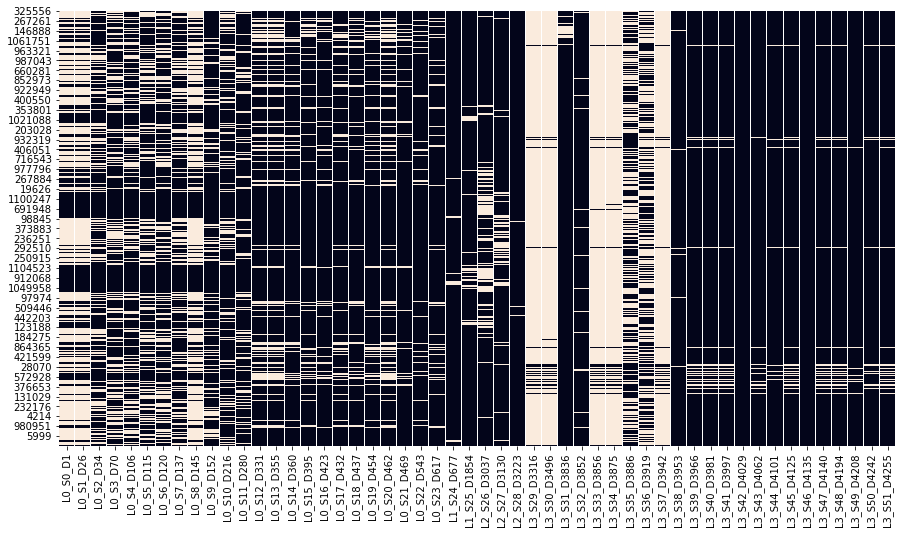

In [31]:
matplotlib.pyplot.rcParams['figure.figsize'] = (15.0, 8.0)
print(df_sorted.shape)
sns.heatmap(df_sorted.drop(['Id', 'StartTime','Response', 'EndTime'], axis=1), annot=False, cbar=False)
plt.show()

# Station 32 を通るものだけ抜き出すとどうなるか。

Numerical Data の分析からエラー率が高かった、Station32についてだけ抜き出してみた。<br>
Station32は、S29-S37 と関連が深そう。

(24543, 56)


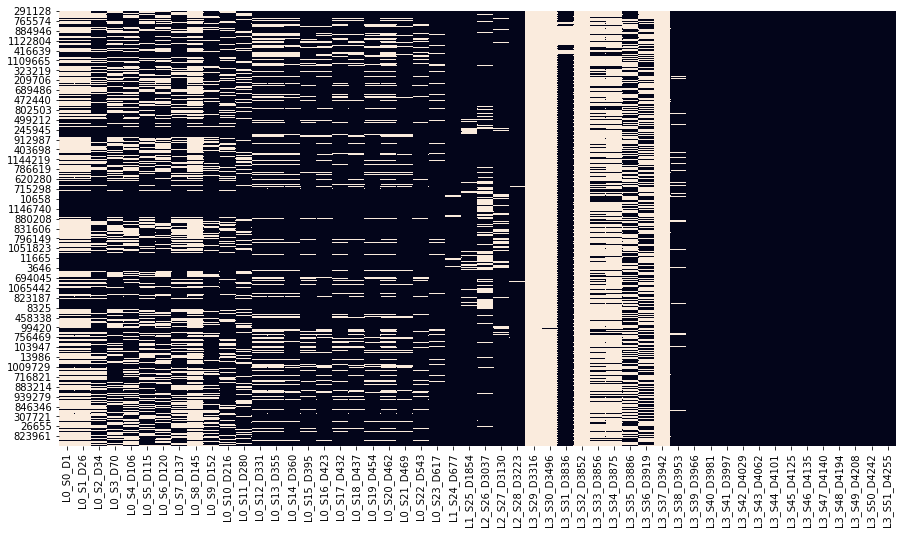

In [32]:
df_sorted_s32_only = df_sorted[df_sorted['L3_S32_D3852'] == 1]

print(df_sorted_s32_only.shape)
sns.heatmap(df_sorted_s32_only.drop(['Id', 'StartTime','Response', 'EndTime'], axis=1), annot=False, cbar=False)
plt.show()

In [33]:
df_sorted_s32_only.describe()


,Id,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,...,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255,Response,StartTime,EndTime
count,2.454300e+04,24543.000000,24543.000000,24543.000000,24543.000000,24543.000000,24543.000000,24543.000000,24543.000000,24543.000000,...,24543.0,24543.0,24543.0,24543.0,24543.0,24543.0,24543.0,24543.000000,24543.000000,24543.000000
mean,1.176091e+06,0.583751,0.583547,0.294707,0.289410,0.292059,0.292181,0.293607,0.290551,0.583669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045064,853.104718,863.726558
std,6.829812e+05,0.492946,0.492980,0.455920,0.453498,0.454718,0.454774,0.455423,0.454026,0.492960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207448,493.248003,492.635914
min,1.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020000,0.530000
25%,5.900935e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,375.940000,416.705000
50%,1.160180e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,888.970000,895.120000
75%,1.772178e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1291.670000,1297.860000
max,2.367492e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1713.600000,1718.480000


ランダムサンプル100個くらいでみてみる。<br>
station32はS29,30,S33, S34, (S35 or S36) と直列。 S39-S51 とは独立になっていそうだ。
S28 , S32 の両方を通るものは、わずかだがいる。

(123, 56)


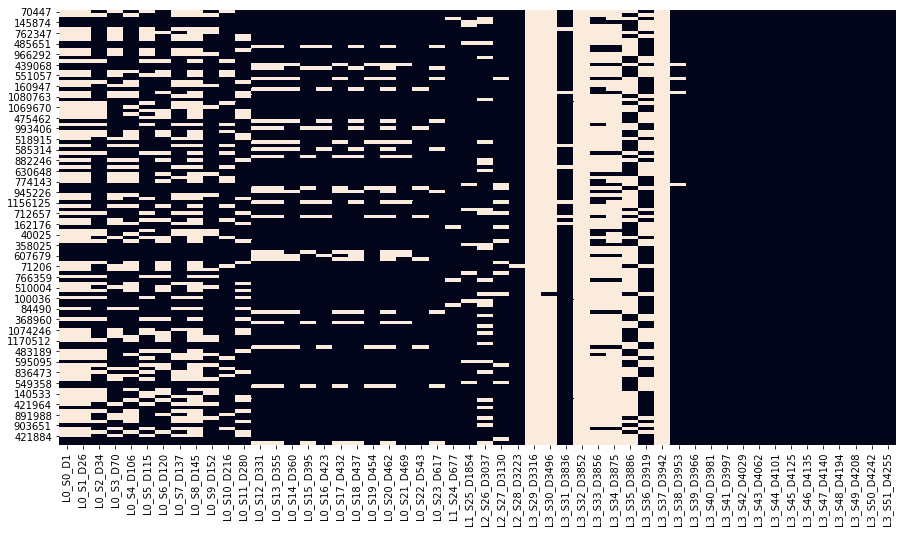

In [41]:
df_sorted_s32_only_sample = df_sorted[df_sorted['L3_S32_D3852'] == 1].sample(frac=0.005)

print(df_sorted_s32_only_sample.shape)
sns.heatmap(df_sorted_s32_only_sample.drop(['Id', 'StartTime','Response', 'EndTime'], axis=1), annot=False, cbar=False)
plt.show()

(96, 56)


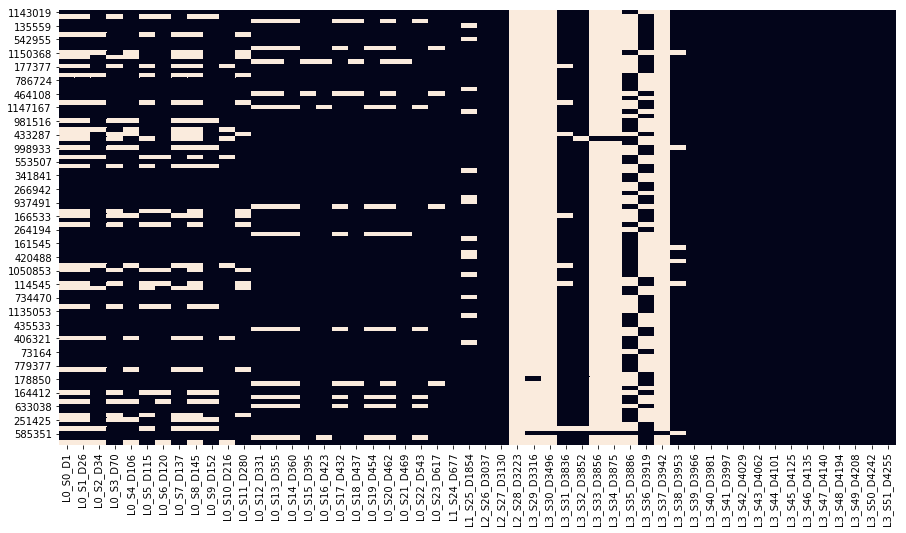

In [42]:
df_sorted_s28_only_sample = df_sorted[df_sorted['L2_S28_D3223'] == 1].sample(frac=0.01)

print(df_sorted_s28_only_sample.shape)
sns.heatmap(df_sorted_s28_only_sample.drop(['Id', 'StartTime','Response', 'EndTime'], axis=1), annot=False, cbar=False)
plt.show()

S28-S29-S30-S33-S34-S36-S37<br>
S28-S29-S30-S33-S34-S35-S37<br>
S28-S29-S30-S31-S33-S34-S36-S37<br>
S28-S29-S30-S31-S33-S34-S35-S37<br>
S28-S29-S30-S31-S32-S33-S34-S36-S37<br>
S28-S29-S30-S32-S36-S37<br>

S28-S29-S30-S33-S34-S36-S37-S38<br>
S28-S29-S30-S33-S34-S35-S37-S38<br>
S28-S38<br>
